In [1]:
# Test script for controller.jl
push!(LOAD_PATH,pwd())
using CarMpcUtils
using CarMpc
# using PyCall, PyPlot
# @pyimport matplotlib.patches as patches
# pygui(true)

### Simulation parameters
simLength = 100

# initialize vehicle
vehicle = Vehicle([122.724, 44.3005, 2.615, 5.0], model=kinematicBicycleDiscrete)   # RFS 0128

# tuning parameters
tuning = Tuning(dt = 0.2, dtMPC = 0.2, N = 20,
                Q = [0.5, 0.5, 10.0, 0.0], R = [20.0, 2.0],
                P = [1000.0, 20.0], vRef = 10.0, dSafe = 5.0,
                eYRef = 0.0, TTC = 3.0, eYSafe = 0.5)

# map
Map = TrackMap("maps/RFS_2Lanes_Speed_0128.mat")

CarMpcUtils.TrackMap(2x1233 Array{Float64,2}:
 -151.506  -151.208  -150.901  -150.585  …  -153.603  -153.936  -154.261
 -302.809  -301.841  -300.896  -299.951     -295.503  -296.437  -297.36 ,[0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0  …  621.0,622.0,623.0,624.0,625.0,626.0,627.0,628.0,629.0,630.0],[2.88194,2.82986,2.79948,2.70833,2.68663,2.64757,2.60417,2.54774,2.46962,2.22656  …  9.48351,9.28819,9.0625,8.84983,8.52865,8.07292,7.59549,7.01823,6.05469,4.85677],2x2 Array{Int64,2}:
   1   603
 602  1233,2,[-122.3318,37.9168],3.4,25,5,5,[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9  …  99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0])

In [2]:
### Initialize MPC problem and solve dummy problem
mpc = initializeMPCProblem(vehicle, tuning)
nz, nu = mpc.nz, mpc.nu


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      331
Number of nonzeros in inequality constraint Jacobian.:      156
Number of nonzeros in Lagrangian Hessian.............:      563

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraint

(4,2)

In [4]:
################
##### Main #####
################

### MPC model parameters updated by subscribers
z0 = vehicle.z
u0 = zeros(nu)
USim = zeros(nu,simLength)
ZSim = [z0 zeros(nz,simLength)]

### Main loop
for t=1:simLength
  ### Reference generation
  URef, ZRef = generateReference(z0, Map, tuning, mpc)

  ### Update and solve MPC problem
  ZOpt, UOpt, solveTime = CarMpc.updateSolveMpcProblem(mpc, ZRef[:,2:tuning.N+1], URef, z0, u0)

  ### Update current input
  u0[1:nu] = UOpt[:,1]

  ### Update ego state
  updateEgoState!(vehicle,u0,tuning.dtMPC)
    
    ### Variables for logging
    ZSim[:,t+1] = vehicle.z
    USim[:,t] = u0
end

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      331
Number of nonzeros in inequality constraint Jacobian.:      156
Number of nonzeros in Lagrangian Hessian.............:      563

Total number of variables............................:      120
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:       40
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       40

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4682516e+02 0.00e+00 3.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  

LoadError: LoadError: InterruptException:
while loading In[4], in expression starting on line 12

In [5]:
USim

2x100 Array{Float64,2}:
 0.00064071  0.000999038  0.00113066  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0751356   0.130824     0.172609       0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [12]:
ZSim[:,20]

4-element Array{Float64,1}:
 70.997  
 75.519  
  2.59883
  7.70963

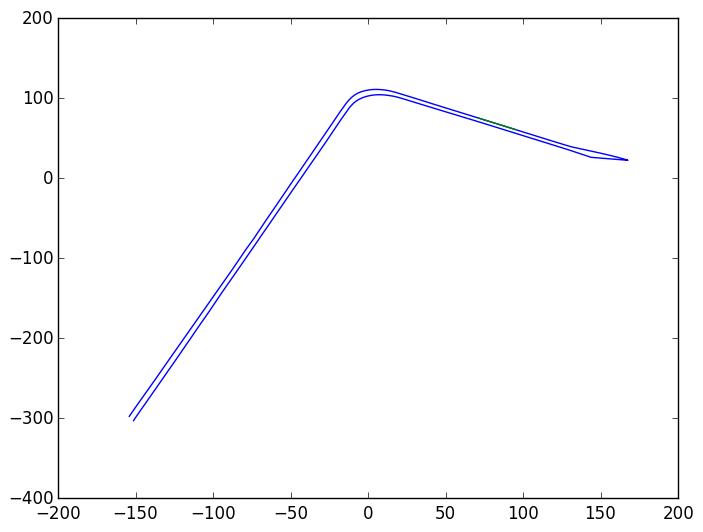

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x320da87d0>

In [15]:
using PyPlot
plot(Map.nodes[1,:]',Map.nodes[2,:]')
plot(ZSim[1,1:20]',ZSim[2,1:20]')